# Fitting Ne lines in a loop
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.39'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'

In [4]:
Ne_files=pf.get_files(path=spectra_path,
file_ext='txt', ID_str='N', 
exclude_str=['diad'], sort=False)

Ne_files[0:5]

['Ne1.txt', 'Ne2.txt', 'Ne3.txt', 'Ne4.txt', 'Ne5.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [6]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

,Raman_shift (cm-1),Intensity,Ne emission line in air
1,818.699523,5000.0,556.27662
9,1117.086987,5000.0,565.66588
16,1310.480205,5000.0,571.92248
19,1398.915133,5000.0,574.82985
23,1447.564622,7000.0,576.44188


### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [8]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

,Ne_Split,Line_1,Line_2,Entered Pos Line 1,Entered Pos Line 2
0,330.477634,1117.086987,1447.564622,1117,1447


## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [9]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

Ne1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

,Peak1_cent,Peak1_height,Peak2_cent,Peak2_height,Peak1_prom,Peak2_prom
8,1116.16583,4551.666504,1447.663174,46932.0,3854.099817,46234.433313


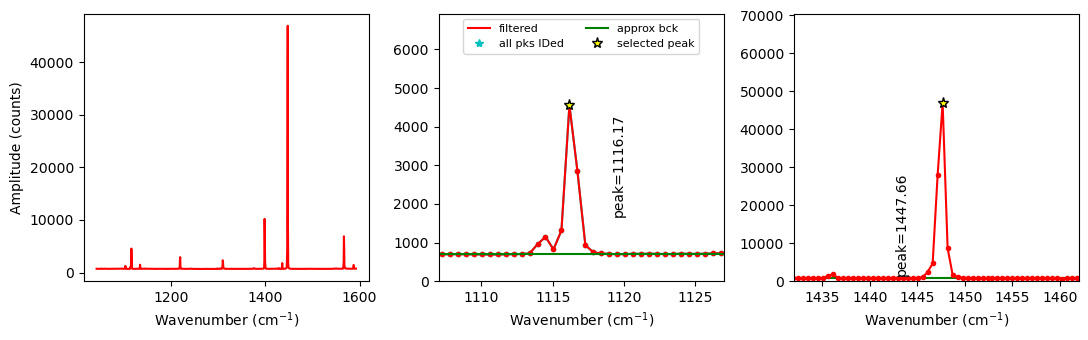

In [10]:
exclude_range_1=None
exclude_range_2=None


Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [11]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [12]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[2, 5],
pk1_sigma=0.6, pk2_sigma=0.5,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

,filename,pk2_peak_cent,pk2_amplitude,pk2_sigma,pk2_gamma,error_pk2,Peak2_Prop_Lor,pk1_peak_cent,pk1_amplitude,pk1_sigma,pk1_gamma,error_pk1,Peak1_Prop_Lor,deltaNe,Ne_Corr,Ne_Corr_min,Ne_Corr_max,residual_pk2,residual_pk1,residual_pk1+pk2
0,Ne1.txt,1447.507791,49150.106948,0.383103,None,1,0.405297,1116.32139,4064.727622,0.405173,None,NaN,0.27796,331.186402,0.99786,NaN,NaN,122.78956,11.05915,133.848711


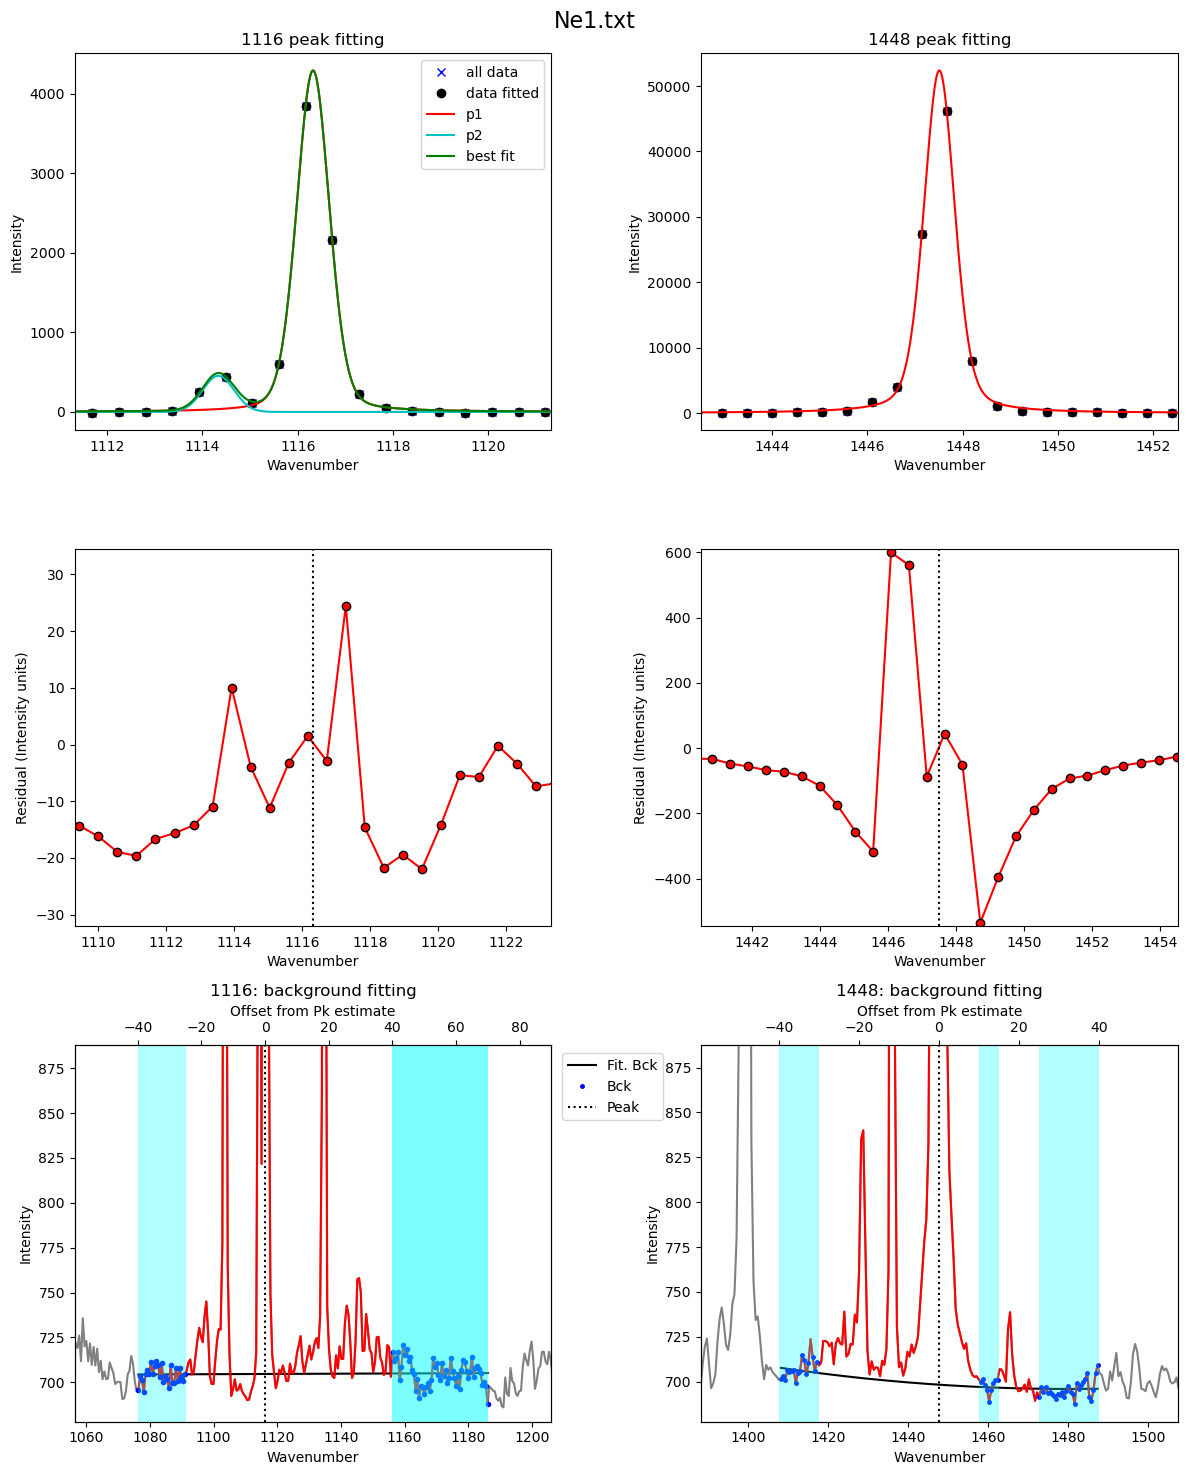

In [13]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=False,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[i], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[i],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[i],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[i],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [14]:
## Update sigma based on this one fit
Ne_Config_tweak=Ne_Config_est
Ne_Config_tweak.pk1_sigma=df_test_params['pk1_sigma'].iloc[0]
Ne_Config_tweak.pk2_sigma=df_test_params['pk2_sigma'].iloc[0]

## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

In [15]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_tweak,
df_fit_params=df_fit_params,                    
plot_figure=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 11.76it/s]


In [16]:
df2

,filename,Ne_Corr,deltaNe,pk2_peak_cent,pk1_peak_cent,pk2_amplitude,pk1_amplitude,residual_pk2,residual_pk1,pk2_sigma,pk2_gamma,error_pk2,Peak2_Prop_Lor,pk1_sigma,pk1_gamma,error_pk1,Peak1_Prop_Lor,Ne_Corr_min,Ne_Corr_max,residual_pk1+pk2
0,Ne1.txt,0.997860,331.186415,1447.507793,1116.321378,49149.951919,4064.533790,122.790683,11.056615,0.383106,None,1,0.405278,0.405199,None,NaN,0.277758,NaN,NaN,133.847298
1,Ne2.txt,0.997826,331.197497,1447.503005,1116.305508,48194.633173,4249.847563,113.078673,9.905574,0.385742,None,1,0.399792,0.409202,None,NaN,0.289332,NaN,NaN,122.984247
2,Ne3.txt,0.997810,331.202952,1447.521962,1116.319010,46080.582039,3842.889328,109.332691,10.204547,0.389635,None,1,0.403728,0.406029,None,NaN,0.281848,NaN,NaN,119.537238
3,Ne4.txt,0.997783,331.212058,1447.539257,1116.327199,44440.930317,3811.736327,106.963819,10.363761,0.391412,None,1,0.409233,0.408269,None,NaN,0.285950,NaN,NaN,117.327580
4,Ne5.txt,0.997778,331.213526,1447.541012,1116.327486,45288.658020,3947.474002,110.897555,10.918445,0.393316,None,1,0.416375,0.409836,None,NaN,0.292668,NaN,NaN,121.816000
5,Ne6 (1).txt,0.997760,331.219549,1447.534558,1116.315009,44105.485852,3915.579112,102.632973,11.223934,0.394988,None,1,0.405803,0.407016,None,NaN,0.302248,NaN,NaN,113.856907
6,Ne6.txt,0.997776,331.214342,1447.539633,1116.325290,46370.328456,4254.106867,116.139245,11.144897,0.392592,None,1,0.417002,0.404681,None,NaN,0.312660,NaN,NaN,127.284142
7,Ne7.txt,0.997756,331.220989,1447.516894,1116.295905,43261.396205,3835.072358,108.092773,11.095154,0.392970,None,1,0.414040,0.407303,None,NaN,0.314205,NaN,NaN,119.187927
8,Ne8.txt,0.997757,331.220600,1447.524737,1116.304137,43156.982494,3790.657402,103.794067,11.529182,0.392562,None,1,0.416884,0.408457,None,NaN,0.308454,NaN,NaN,115.323249


## Now extract metadata to get a timestamp for each file

In [17]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext='txt', ID_str='N', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['Ne1.txt', 'Ne2.txt', 'Ne3.txt', 'Ne4.txt', 'Ne5.txt']

In [18]:
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=False)
meta.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 35.75it/s]

Done


,filename,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,Ne1.txt,"October 28, 2022\n",October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",11:58:18 AM\n,43098.0,1325.004
1,Ne2.txt,"October 28, 2022\n",October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",12:25:51 PM\n,44751.0,1325.004
2,Ne3.txt,"October 28, 2022\n",October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '17s']",1:02:56 PM\n,46976.0,1325.004
3,Ne4.txt,"October 28, 2022\n",October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",1:34:44 PM\n,48884.0,1325.004
4,Ne5.txt,"October 28, 2022\n",October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '17s']",2:06:40 PM\n,50800.0,1325.004


In [19]:
# Strip away suffix and prefix if needed
print(meta['filename'][0])

Ne1.txt


In [20]:
# remove these to get the pure file name you can compare 
file_m=pf.extracting_filenames_generic(names=meta['filename'],
    prefix=False, str_prefix=None,
   file_type='.txt')
file_m

array(['Ne1', 'Ne2', 'Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne6 (1)', 'Ne7', 'Ne8'],
      dtype=object)

In [21]:
# Do the same for spectra, e.g., work out what you need to strip off
print(df2['filename'][0])

Ne1.txt


In [22]:
file_s=pf.extracting_filenames_generic(names=df2['filename'],
    prefix=False, str_prefix=' ',
   file_type='.txt')
file_s

array(['Ne1', 'Ne2', 'Ne3', 'Ne4', 'Ne5', 'Ne6 (1)', 'Ne6', 'Ne7', 'Ne8'],
      dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [23]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [24]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

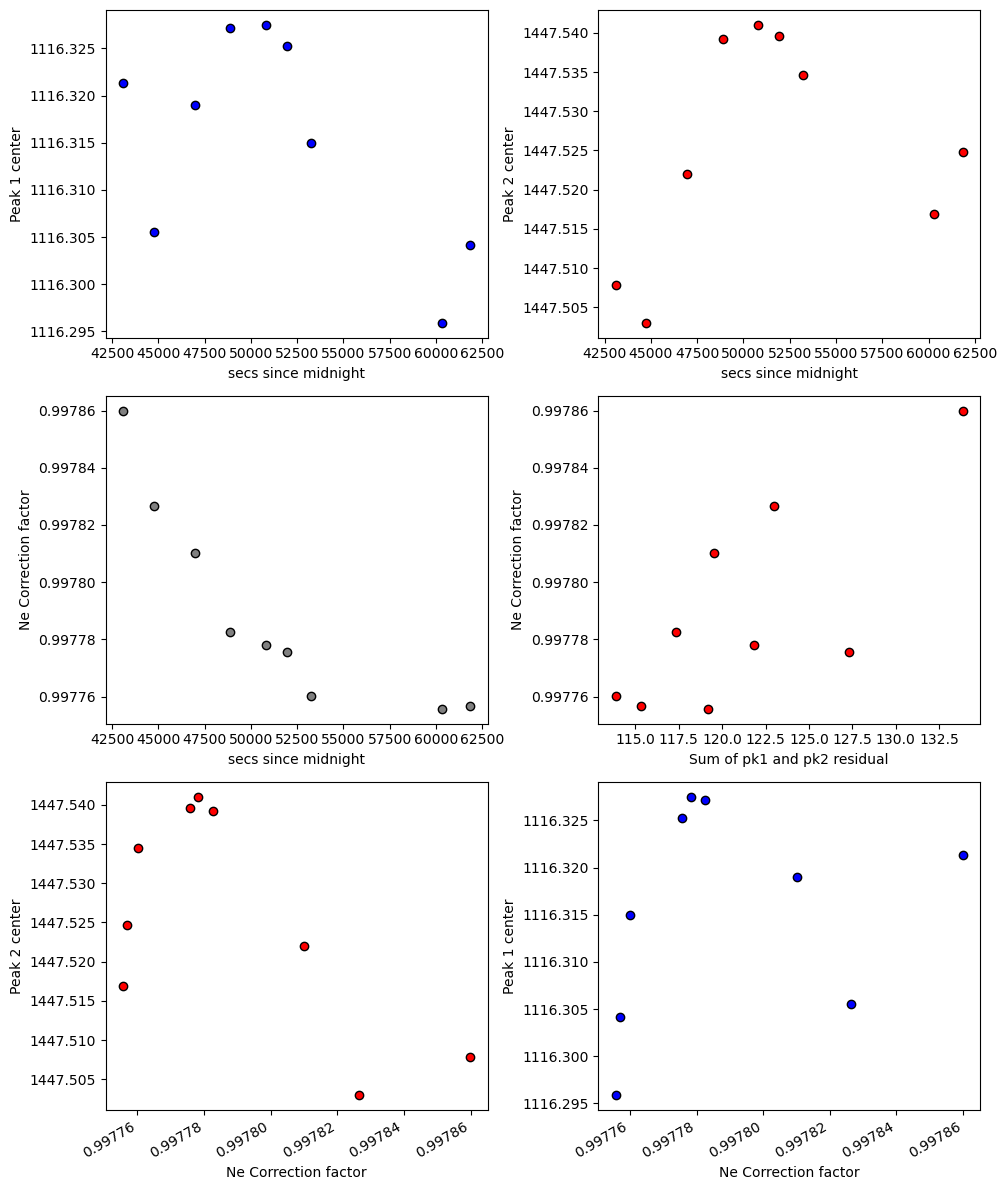

In [25]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [26]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo

,filename_x,Ne_Corr,deltaNe,pk2_peak_cent,pk1_peak_cent,pk2_amplitude,pk1_amplitude,residual_pk2,residual_pk1,pk2_sigma,...,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,Ne1.txt,0.997860,331.186415,1447.507793,1116.321378,49149.951919,4064.533790,122.790683,11.056615,0.383106,...,October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",11:58:18 AM\n,43098.0,1325.004
1,Ne2.txt,0.997826,331.197497,1447.503005,1116.305508,48194.633173,4249.847563,113.078673,9.905574,0.385742,...,October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",12:25:51 PM\n,44751.0,1325.004
2,Ne3.txt,0.997810,331.202952,1447.521962,1116.319010,46080.582039,3842.889328,109.332691,10.204547,0.389635,...,October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '17s']",1:02:56 PM\n,46976.0,1325.004
3,Ne4.txt,0.997783,331.212058,1447.539257,1116.327199,44440.930317,3811.736327,106.963819,10.363761,0.391412,...,October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",1:34:44 PM\n,48884.0,1325.004
4,Ne5.txt,0.997778,331.213526,1447.541012,1116.327486,45288.658020,3947.474002,110.897555,10.918445,0.393316,...,October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '17s']",2:06:40 PM\n,50800.0,1325.004
5,Ne6 (1).txt,0.997760,331.219549,1447.534558,1116.315009,44105.485852,3915.579112,102.632973,11.223934,0.394988,...,October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",2:47:12 PM\n,53232.0,1325.004
6,Ne6.txt,0.997776,331.214342,1447.539633,1116.325290,46370.328456,4254.106867,116.139245,11.144897,0.392592,...,October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",2:25:28 PM\n,51928.0,1325.004
7,Ne7.txt,0.997756,331.220989,1447.516894,1116.295905,43261.396205,3835.072358,108.092773,11.095154,0.392970,...,October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",4:45:22 PM\n,60322.0,1325.004
8,Ne8.txt,0.997757,331.220600,1447.524737,1116.304137,43156.982494,3790.657402,103.794067,11.529182,0.392562,...,October,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",5:10:44 PM\n,61844.0,1325.004


In [27]:
df_combo_sort.to_clipboard(excel=True)

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right

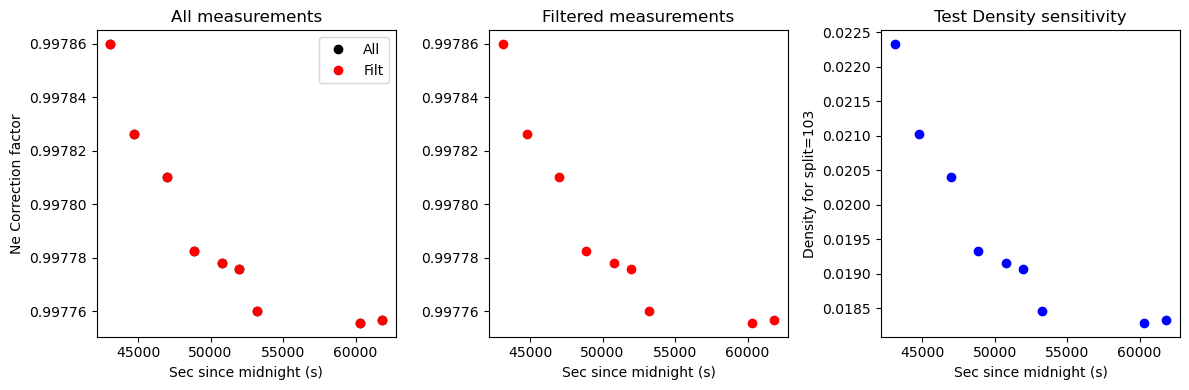

In [28]:
filt=pf.filter_Ne_Line_neighbours(Corr_factor=df_combo['Ne_Corr'], 
                    number_av=5, offset=0.0002)
# Now lets plot this to see
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='All')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Filt')
ax1.legend()
ax2.plot(df_combo['sec since midnight'], filt,  'or', label='Filt')

test_split=103
split=filt*test_split
density_test=pf.calculate_density_cornell(temp='SupCrit', Split=split)
ax3.plot(df_combo['sec since midnight'].loc[density_test['Preferred D']>0],
         density_test['Preferred D'].loc[density_test['Preferred D']>0], 'ob')


ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')
ax2.set_xlabel('Sec since midnight (s)')
ax2.set_title('Filtered measurements')
ax3.set_xlabel('Sec since midnight (s)')
ax3.set_ylabel('Density for split=' + str(test_split))
ax3.set_title('Test Density sensitivity')
fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

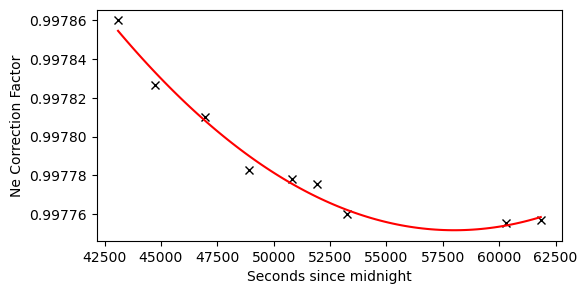

In [29]:
df_combo_filt=df_combo[density_test['Preferred D']>0]
model, fig=pf.reg_Ne_lines_time(df=df_combo_filt, N_poly=2, fit='poly')

## SAving as pickle, can then load as a pickle

In [30]:
import pickle
with open('Ne_Line_Regression_Example_cali.pck', 'wb') as file_handle:
    pickle.dump(model, file_handle)